In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit import RDLogger
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.manifold import TSNE
from mlinsights.mlmodel import PredictableTSNE
from hdbscan import HDBSCAN
from chembl_downloader.contrib import get_document_smi_df

sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
RDLogger.DisableLog('rdApp.*')
seed = 794

RDKit WARNING: [22:40:20] Enabling RDKit 2019.09.2 jupyter extensions


In [2]:
oxrs = [("CHEMBL3098111", "Merck" ),  ("CHEMBL3867477", "Merck" ),  ("CHEMBL2380240", "Rottapharm" ),
             ("CHEMBL3352684", "Merck" ),  ("CHEMBL3769367", "Merck" ),  ("CHEMBL3526050", "Actelion" ),
             ("CHEMBL3112474", "Actelion" ),  ("CHEMBL3739366", "Heptares" ),  ("CHEMBL3739395", "Actelion" ), 
             ("CHEMBL3351489", "Eisai" )]

In [3]:
fps = []
docs = []
companies = []
mol_list = []
for cid, company in oxrs:
    df = get_document_smi_df(cid)
    for smiles in df.canonical_smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            mol_list.append(mol)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            docs.append(cid)
            companies.append(company)
            fps.append(arr)
fps = np.array(fps)
companies = np.array(companies)
docs = np.array(docs)

trainIDX, testIDX = train_test_split(range(len(fps)), random_state=seed)

In [4]:
def tanimoto_dist(ar1, ar2):
    a = np.dot(ar1, ar2)
    b = ar1 + ar2 - ar1*ar2
    return 1 - a/np.sum(b)

clusterer = HDBSCAN(algorithm='best', min_samples=5, metric='pyfunc', func=tanimoto_dist)
clusterer.fit(fps)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='pyfunc', min_cluster_size=5, min_samples=5, p=None,
        prediction_data=False)

In [5]:
tsne = TSNE(random_state=seed)
res = tsne.fit_transform(fps)

<Figure size 432x288 with 0 Axes>

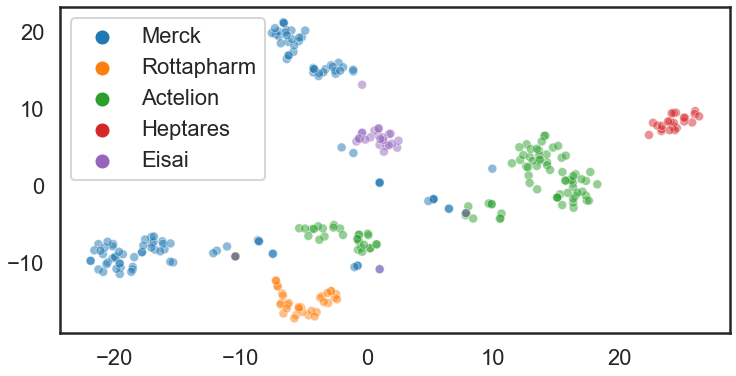

In [6]:
plt.clf()
plt.figure(figsize=(12, 6))
sns.scatterplot(x=res[:,0], y=res[:,1], hue=companies, **plot_kwds)

<Figure size 432x288 with 0 Axes>

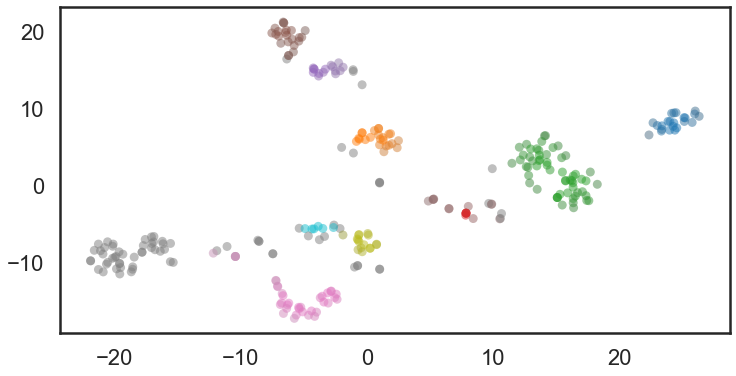

In [7]:
plt.clf()
plt.figure(figsize=(12, 6))
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                 if col >= 0 else (0.5, 0.5, 0.5) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(res[:,0], res[:,1], c=cluster_colors, **plot_kwds)

## random split

In [8]:
trainFP = fps[trainIDX]
train_mol = [mol_list[i] for i in trainIDX]

testFP = fps[testIDX]
test_mol = [mol_list[i] for i in testIDX]

<Figure size 432x288 with 0 Axes>

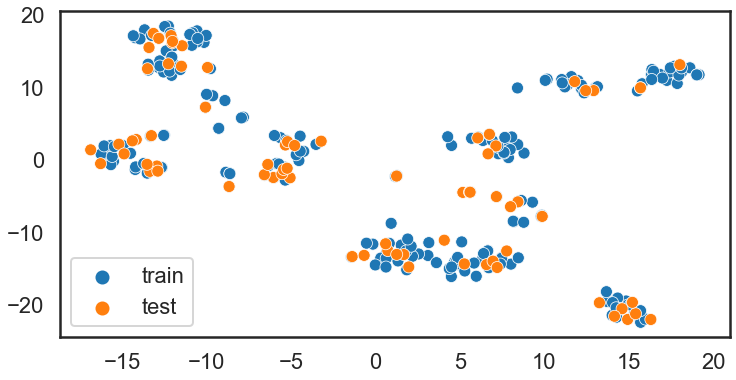

In [9]:
allFP = np.vstack([trainFP, testFP])
tsne_ref = TSNE(random_state=seed)
res = tsne_ref.fit_transform(allFP)
plt.clf()
plt.figure(figsize=(12, 6))
sns.scatterplot(x=res[:,0], y=res[:,1], hue=['train' for i in range(len(trainFP))] + ['test' for i in range(len(testFP))])

In [10]:
rfr = RandomForestRegressor(random_state=seed)
tsne1 = TSNE(random_state=seed)
pred_tsne_rfr = PredictableTSNE(transformer=tsne1, estimator=rfr, keep_tsne_outputs=True)
pred_tsne_rfr.fit(trainFP, list(range(len(trainFP))))

/home/takayuki/anaconda3/envs/chemo37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


PredictableTSNE(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators='warn',
                                                n_jobs=None, oob_score=False,
                                                random_state=794, verbose=0,
                                                warm_start=False),
                keep_tsne_outputs=True, normalize=True, normali

<Figure size 432x288 with 0 Axes>

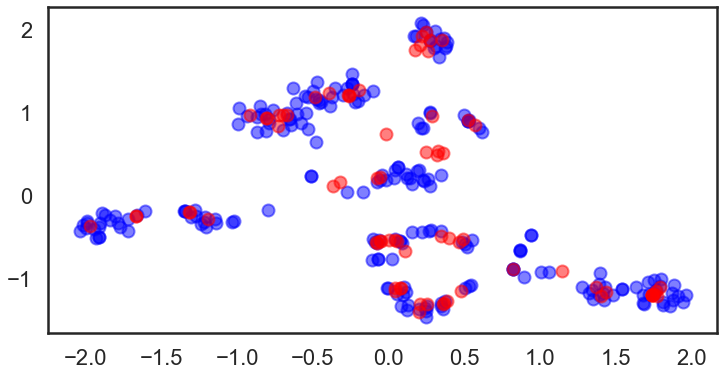

In [11]:
pred1 = pred_tsne_rfr.transform(testFP)
plt.clf()
plt.figure(figsize=(12, 6))
plt.scatter(pred_tsne_rfr.tsne_outputs_[:,0], pred_tsne_rfr.tsne_outputs_[:,1], c='blue', alpha=0.5)
plt.scatter(pred1[:,0], pred1[:,1], c='red', alpha=0.5)

In [12]:
gbr = GaussianProcessRegressor(random_state=seed)
tsne2 = TSNE(random_state=seed)
pred_tsne_gbr = PredictableTSNE(transformer=tsne2, estimator=gbr, keep_tsne_outputs=True)
pred_tsne_gbr.fit(trainFP, list(range(len(trainFP))))

PredictableTSNE(estimator=GaussianProcessRegressor(alpha=1e-10,
                                                   copy_X_train=True,
                                                   kernel=None,
                                                   n_restarts_optimizer=0,
                                                   normalize_y=False,
                                                   optimizer='fmin_l_bfgs_b',
                                                   random_state=794),
                keep_tsne_outputs=True, normalize=True, normalizer=None,
                transformer=TSNE(angle=0.5, early_exaggeration=12.0,
                                 init='random', learning_rate=200.0,
                                 method='barnes_hut', metric='euclidean',
                                 min_grad_norm=1e-07, n_components=2,
                                 n_iter=1000, n_iter_without_progress=300,
                                 perplexity=30.0, random_state=794, verbose=0))

<Figure size 432x288 with 0 Axes>

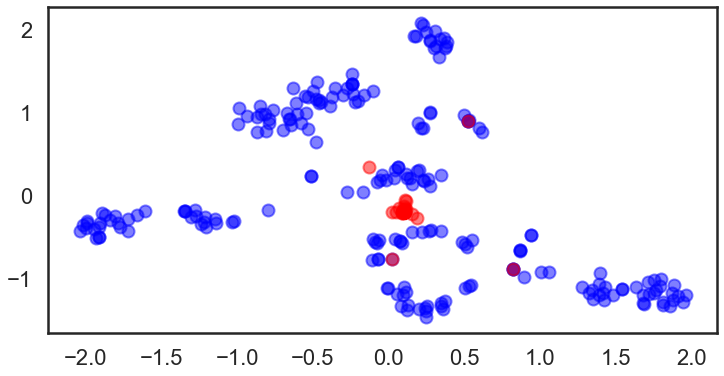

In [13]:
pred2 = pred_tsne_gbr.transform(testFP)
plt.clf()
plt.figure(figsize=(12, 6))
plt.scatter(pred_tsne_gbr.tsne_outputs_[:,0], pred_tsne_gbr.tsne_outputs_[:,1], c='blue', alpha=0.5)
plt.scatter(pred2[:,0], pred2[:,1], c='red', alpha=0.5)

In [14]:
allmol = train_mol + test_mol
fps2 = []


In [15]:
clusterer2 = HDBSCAN(algorithm='best', min_samples=5, metric='pyfunc', func=tanimoto_dist)
for mol in allmol:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    fps2.append(arr)
fps2 = np.array(fps2)

In [16]:
clusterer2.fit(fps2)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='pyfunc', min_cluster_size=5, min_samples=5, p=None,
        prediction_data=False)

<Figure size 432x288 with 0 Axes>

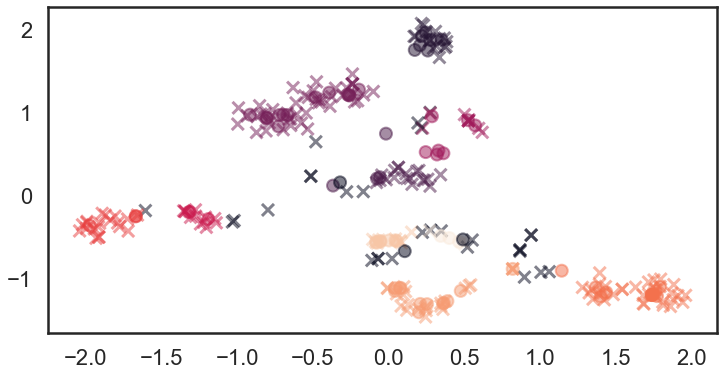

In [17]:
plt.clf()
plt.figure(figsize=(12, 6))
plt.scatter(pred_tsne_rfr.tsne_outputs_[:,0], pred_tsne_rfr.tsne_outputs_[:,1], c=clusterer2.labels_[:len(trainFP)], alpha=0.5, marker='x')
plt.scatter(pred1[:,0], pred1[:,1], c=clusterer2.labels_[len(trainFP):], alpha=0.5, marker='o')